In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)
print("Libraries imported.")

TensorFlow Version: 2.19.0
Libraries imported.


In [4]:
# Cell 2: Configure Image Data Generator
print("Configuring image data generators...")

# Define the path to your image data
base_dir = '../data/raw/leaf_images/'

# Check if the directory exists and has subdirectories
try:
    if not os.path.exists(base_dir) or not os.listdir(base_dir):
        raise FileNotFoundError
except FileNotFoundError:
    print(f"ERROR: The directory '{base_dir}' is empty or does not exist.")
    print("Please add categorized image folders (e.g., 'banana_healthy') with images inside before proceeding.")
    raise

# Keras's ImageDataGenerator is a powerful tool for loading and augmenting images from directories.
# We'll split our data into 80% for training and 20% for validation.
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values from 0-255 to 0-1
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of images for validation
)

# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16

# Create a generator for training data
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    subset='training' # Set as training data
)

# Create a generator for validation data
validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation' # Set as validation data
)

# Print the class labels found by the generator
class_labels = list(train_generator.class_indices.keys())
print("\nFound the following class labels:")
for i, label in enumerate(class_labels):
    print(f"{i}: {label}")

Configuring image data generators...
Found 1448 images belonging to 9 classes.
Found 356 images belonging to 9 classes.

Found the following class labels:
0: arecanut_healthy
1: arecanut_pest_damage
2: banana_healthy
3: banana_nutrient_deficiency
4: banana_pest
5: banana_pest_damage
6: black_pepper_healthy
7: black_pepper_pest
8: black_pepper_pest_damage


In [5]:
# Cell 3: Build the Vision Model using Transfer Learning
print("\nBuilding the vision model...")

# Load the MobileNetV2 model, pre-trained on ImageNet, but without its final classification layer.
base_model = MobileNetV2(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    include_top=False, # We will add our own custom top layer
    weights='imagenet'
)

# Freeze the layers of the base model. We don't want to change the pre-trained weights during initial training.
base_model.trainable = False

# Create our custom top layers
# 1. Take the output of the base model
inputs = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
x = base_model(inputs, training=False)
# 2. Add a pooling layer to reduce dimensions
x = GlobalAveragePooling2D()(x)
# 3. Add a dropout layer to prevent overfitting
x = Dropout(0.3)(x)
# 4. Add our final dense layer for classification. The number of neurons must match the number of classes.
outputs = Dense(len(class_labels), activation='softmax')(x)

# Combine the base model and our custom top layers into the final model
model = Model(inputs, outputs)

# Compile the model
# For multi-class classification, we use 'categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Building the vision model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Cell 4: Train the Model
print("\nTraining the vision model... (This will be slow without a GPU)")

# Train the model using the data generators
history = model.fit(
    train_generator,
    epochs=5, # Start with 5 epochs for initial training
    validation_data=validation_generator,
    verbose=1
)

print("Model training complete.")


Training the vision model... (This will be slow without a GPU)


c:\Final_Year_Project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 1/91 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - accuracy: 0.0000e+00 - loss: 3.3694

c:\Final_Year_Project\venv\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
c:\Final_Year_Project\venv\Lib\site-packages\PIL\JpegImagePlugin.py:887: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


91/91 ━━━━━━━━━━━━━━━━━━━━ 93s 938ms/step - accuracy: 0.6740 - loss: 0.9340 - val_accuracy: 0.8848 - val_loss: 0.3838
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 472ms/step - accuracy: 0.8860 - loss: 0.3672 - val_accuracy: 0.9213 - val_loss: 0.2609
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 92s 574ms/step - accuracy: 0.9227 - loss: 0.2667 - val_accuracy: 0.9242 - val_loss: 0.2048
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 45s 495ms/step - accuracy: 0.9254 - loss: 0.2300 - val_accuracy: 0.9494 - val_loss: 0.1829
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 44s 481ms/step - accuracy: 0.9406 - loss: 0.1963 - val_accuracy: 0.9270 - val_loss: 0.2065
Model training complete.



Plotting training history...


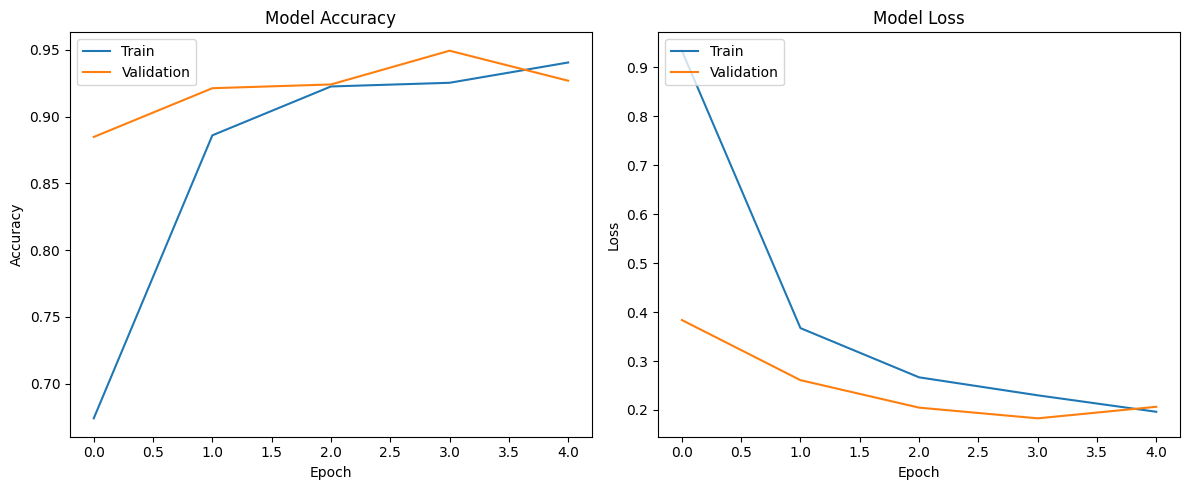

In [7]:
# Cell 5: Plot Training History
print("\nPlotting training history...")

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
# Cell 6: Save the Trained Model
print("\nSaving the trained vision model...")

# Define the path to save the model
model_dir = '../backend/models/'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'leaf_vision_model.h5')

# Save the model
model.save(model_path)

print(f"Vision model saved successfully to: {model_path}")


Saving the trained vision model...
Vision model saved successfully to: ../backend/models/leaf_vision_model.h5
